In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
class Colors(Enum):
    blue = '#0A85FF'
    darkblue = '#00264D'
    green = '#99CC00'
    darkgreen = '#739900'

In [3]:
battleground_path = '../data/battleground-state-changes.csv'
df = pd.read_csv(battleground_path)

In [4]:
# Restructure data frame for easier access to Biden and Trump votes

def get_candidate_votes(row):
    if row['leading_candidate_name'] == 'Biden':
        row['biden_votes'] = row['leading_candidate_votes']
        row['trump_votes'] = row['trailing_candidate_votes']
    elif row['leading_candidate_name'] == 'Trump':
        row['biden_votes'] = row['trailing_candidate_votes']
        row['trump_votes'] = row['leading_candidate_votes']
    return row

df = df.apply(get_candidate_votes, axis=1)

In [5]:
"""
=================
IT WAS WRITTEN ORIGINALLY BUT FINALLY THE SOLUTION WITH LINALG IS CHOSEN
KEPT FOR FURTHER PURPOSES 
=================
Ordinary least squares, or linear least squares, 
estimates the parameters in a regression model by minimizing the sum of the squared residuals.
Our aim is to calculate the values m (slope) and b (y-intercept) in the equation of a line

y = mx + b, Where:
y = how far up
x = how far along
m = Slope or Gradient (how steep the line is)
b = the Y Intercept (where the line crosses the Y axis)

steps: https://www.mathsisfun.com/data/least-squares-regression.html
"""
class LinearRegression_LSM():
        
    def __init__(self, w=0, b=0):
        # if slop and intercept is not given
        # init with zeros 
        self.w = w
        self.b = b


    def fit(self, X, y):
        # Define the Linear Regression here
        squared_x = np.power(X, 2)
        mult_xy = np.multiply(X, y)

        #  Step 2: Sum all x, y, x2 and xy
        sum_x = np.sum(X)
        sum_y = np.sum(y)
        sum_squared_x = np.sum(squared_x)
        sum_mult_xy = np.sum(mult_xy)
        
        # Step 3: Calculate Slope m:
        # m =  (N Σ(xy) − Σx Σy) / (N Σ(x2) − (Σx)2)
        N = mult_xy.size
        self.w = (N * sum_mult_xy - sum_x * sum_y) / (N * sum_squared_x -  sum_x**2)
        
        # Step 4: Calculate Intercept b:
        # b =  (Σy − m Σx) / N
        self.b = (sum_y - self.w * sum_x ) / N
        
    
    def predict(self, X):
        """ 
        Define the line here.
        Map x to it's y coordinates. The set {(x,y) | x from input, y from output} 
        should define your line.
        In this case x will be percentages reported like
        np.linspace(0.94, 1, 100).reshape([-1,1]) from 94% to 100%
        in Georgia
        """
        # Step 0: slope and intercept should be calculated in fit()
        
        predicted_votes = []
        
        # Step 5: Assemble the equation of a line:
        # y = mx + b

        for x in X:
            y = np.dot(self.w, x) + self.b
            predicted_votes.append(y)
            
        return np.array(predicted_votes).reshape([-1,1])



In [44]:
"""
SOLUTION from Anton with Linalg (main goal is to check how data differs with these two methods)
"""
def fit(X, y):
    lbd = 1e-6
    bias = np.ones([X.shape[0], 1])
    # expand data matrix with ones-bias
    X_b = np.hstack([X, bias])
    # transpose matrix for mult
    Xt = np.transpose(X_b)
    XtX = Xt.dot(X_b)
    # if determinant of an array is zero
    if np.linalg.det(XtX) == 0.0:
        print("Matrix is singular, using Ridge Regression method...")
        perturbation = np.identity(XtX.shape[0]) * lbd
        XtX += perturbation
    # Why Do We Need an Inverse?
    # Because with matrices we don't divide! There is no concept of dividing by a matrix.
    # But we can multiply by an inverse, which achieves the same thing.
    w_b = np.linalg.inv(XtX).dot(Xt).dot(y)

    return LinearRegression(*w_b)

class LinearRegression():
        
    def __init__(self, w=0, b=0):
        # if slop and intercept is not given
        # init with zeros 
        self.w = w
        self.b = b
    
    def predict(self, X):
        """ 
        Define the line here.
        Map x to it's y coordinates. The set {(x,y) | x from input, y from output} 
        should define your line.
        In this case x will be percentages reported like
        np.linspace(0.94, 1, 100).reshape([-1,1]) from 94% to 100%
        in Georgia
        """        
        predicted_votes = []
        
        return np.dot(self.w, X) + self.b 

In [45]:
def state_df(df, state_name, est_total_count, threshold):
    """ state_name must be something like 'Pennsylvania (EV: 20)' """
    df_tmp = df.loc[df.state == state_name].copy()
    df_tmp['percent_reporting'] = df_tmp['total_votes_count'] / est_total_count
    df_tmp['trump_lead'] = (df_tmp['trump_votes'] - df_tmp['biden_votes']) / df_tmp['total_votes_count']
    df_tmp = df_tmp.sort_values('percent_reporting', axis=0, ascending=False)

    # Only view votes that were counted before *threshold* were reported
    df_tmp = df_tmp[df_tmp['percent_reporting'] <= threshold]

    X = df_tmp['percent_reporting'].to_numpy().reshape([-1, 1])
    y = df_tmp['trump_lead'].to_numpy()
    # Fit X to y using Linear Regression
    linear_tmp = fit(X, y)
    return linear_tmp, df_tmp

At what percentage of reported votes will Biden lead over Trump?

In [46]:
def plot_state(lin_model, df_local, sub_ax, state_name, est_count, threshold):
    sub_ax.scatter(df_local['percent_reporting'] * 100, df_local['trump_lead'] * 100, marker='x', s=100, color=Colors.blue.value)
    x = np.linspace(0.8, 1, 100).reshape([-1,1])
    y = lin_model.predict(x)
    sub_ax.set_xlim([85, 100])
    sub_ax.set_xticks(range(80, 101, 2))
    sub_ax.plot(x * 100, y * 100, linestyle='--', color=Colors.darkblue.value)
    sub_ax.hlines(y=0, xmin=80, xmax=100, linestyle='--', color='black')
    sub_ax.set_title(f'{state_name.split(" (")[0]} (Expected total vote = {int(est_count):,d})')
    sub_ax.set_xlabel("Percentage reported")

Estimated Biden lead at 100% votes counted in Pennsylvania   : 4.040243392045673%
Estimated Biden lead at 100% votes counted in Nevada         : 3.4910883506837633%
Estimated Biden lead at 100% votes counted in North Carolina : -1.1179846338430028%
Estimated Biden lead at 100% votes counted in Georgia        : 0.48323049676989305%


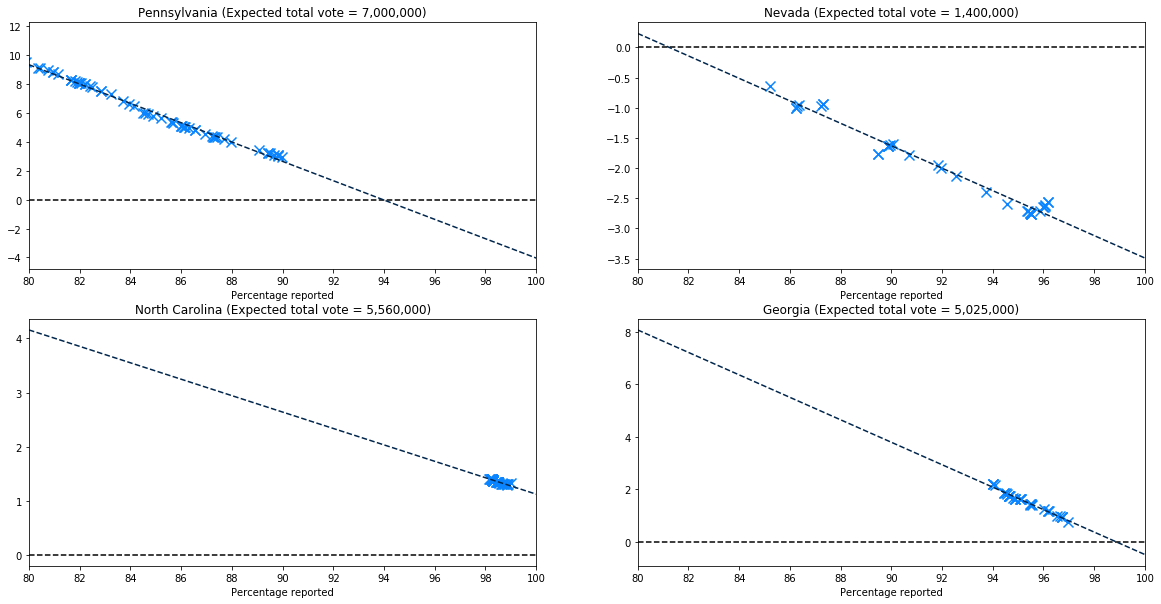

In [47]:
"""
state_info is a list whose elements are tuples of information about the given state:
        (Name (for df), estimated total votes, percentage_threshold)
"""
state_infos = [("Pennsylvania (EV: 20)"  , int(7e+6)    , 0.90),
               ("Nevada (EV: 6)"         , int(1.4e+6)  , 0.97),
               ("North Carolina (EV: 15)", int(5.56e+6) , 0.99),
               ("Georgia (EV: 16)"       , int(5.025e+6), 0.97)]

plot_rows = int(np.ceil(len(state_infos) / 2))
fig, ax = plt.subplots(plot_rows, 2, figsize=(20, 10))

for i, state_info in enumerate(state_infos):
    lin_model, df_tmp = state_df(df, *state_info)
    plot_state(lin_model, df_tmp, ax[i//2, i%2], *state_info)
    print(f'Estimated Biden lead at 100% votes counted in {state_info[0].split(" (")[0]:15s}: {-lin_model.predict(1.0) * 100}%')